Проект: Обучение с учителем: качество модели

**Описание проекта:**

Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

Вшему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных:**

***market_file.csv*** - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
* id — номер покупателя в корпоративной базе данных.
* Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
* Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
* Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
* Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
* Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
* Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

***market_money.csv***
* Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* Выручка — сумма выручки за период.

***market_time.csv***
* Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* id — номер покупателя в корпоративной базе данных.
* Период — название периода, во время которого зафиксировано общее время.
* минут — значение времени, проведённого на сайте, в минутах.

***money.csv***
* Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
* id — номер покупателя в корпоративной базе данных.
* Прибыль — значение прибыли.

## Загрузка и изучение данных

Импорт библиотек

In [6]:
# !pip install shap
# !pip install phik
# !pip install -U scikit-learn 

In [7]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from phik import resources, report

from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import statsmodels.api as sm
import shap

pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, confusion_matrix




### Загрузка данных

In [10]:
market_file = pd.read_csv('market_file.csv')
market_money = pd.read_csv('market_money.csv')
market_time = pd.read_csv('market_time.csv')
money = pd.read_csv('money.csv', sep=';') #В данны разделитель ;

### Изучение данных

Создадим функцию преобразования названия колонок в нижний регистр, вместо пробелов нижнее подчеркивание, удаление начальных и последних пробелов. На вход функция принимает датафрейм, возвращает функция информацию по таблице.

In [13]:
# Создаем функцию
def change_columns (df):
    columns = df.columns
    for column in columns:
        new_column = column.strip().lower().replace(' ', '_')
        df.rename(columns={column: new_column}, inplace=True)
    return df.info()

Создадим функцию для проверки уникальность значений, для выявления ошибок в написании. На вход функция принимает датафрейм и список колонок, возвращает название колонки и уникальные значения.

In [15]:
def value_count (df, colums):
    for column in colums:
        print(f'------------------\n{column}:\n\n{df[column].value_counts()}\n')

Далее по каждой таблице посмотррим на первые строки, для первичного анализа данных.

#### Данные market_file

Преообразуем названия колонок и выводим информацию

In [19]:
change_columns(market_file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

In [20]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2


Проверяем уникальные значения

In [22]:
colums_market_file = ['покупательская_активность','тип_сервиса', 'разрешить_сообщать', 'популярная_категория']
value_count(market_file, colums_market_file)

------------------
покупательская_активность:

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

------------------
тип_сервиса:

тип_сервиса
стандарт     914
премиум      376
стандартт     10
Name: count, dtype: int64

------------------
разрешить_сообщать:

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

------------------
популярная_категория:

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64



*Вывод:*
* Видим, что есть пробелы в названии значений, надо будет убрать.
* Видим, что в "тип_сервиса" некорректны значения.
* Преобразовывать тип данных не требуется
* Пропусков нет

#### Данные market_money

Преообразуем названия колонок и выводим информацию

In [26]:
change_columns(market_money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [27]:
market_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,3293.10
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,4472.00
4,215349,текущий_месяц,4971.60


Проверяем уникальные значения

In [29]:
colums_market_money = ['период']
value_count(market_money, colums_market_money)

------------------
период:

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64



*Вывод:*
* Преобразуем значения, что бы убрать наверняка пробелы в конце
* Видим, что нет некорректны значений.
* Преобразовывать тип данных не требуется
* Пропусков нет

#### Данные market_time

Преообразуем названия колонок и выводим информацию

In [33]:
change_columns(market_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [34]:
market_time.head()

,id,период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Проверяем уникальные значения

In [36]:
colums_market_time = ['период']
value_count(market_time, colums_market_time)

------------------
период:

период
текущий_месяц       1300
предыдцщий_месяц    1300
Name: count, dtype: int64



*Вывод:*
* Преобразуем значения, что бы убрать наверняка пробелы в конце
* Видим, некорректное значение "предыдущий_месяц" надо исправить.
* Преобразовывать тип данных не требуется
* Пропусков нет

#### Данные money

Преообразуем названия колонок и выводим информацию

In [40]:
change_columns(money)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


In [41]:
money.head()

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Видим, что в значениях запятные надо исправить на точки. 

*Вывод:*
* Требуется замена запятой на точку.
* Преобразовывать тип данных требуется для прибыли
* Пропусков нет

### Общий вывод

При изучении данных выявлено: 
* В данных нет пропусков
* Необходимо убрать пробелы в начале и в конце значений
* Необходимо преобразовать некорректные значения.
* Преобразования типа данных требуется
* Необходимо проверить дубликаты строк

## Предобработка данных

### Убираем пробелы в начале и в конце значений, корректируем значения

Создаем функцию для удаления пробелов и изменение некоректных значений. На вход принимает датафреймы и словарь для изменения.

In [49]:
# Функция для удаления пробелов и замены значений
def del_spaces (dfs, replace_dict):
    for df in dfs:
        columns = df.columns
        for column in columns:
            if df[column].dtype == 'object':
                df[column] = df[column].replace(replace_dict)
                df[column].str.strip()

Объявляем список датафреймов и словаря

In [51]:
dfs = [market_file, market_money, market_time, money]

replace_dict = {
    'стандартт': 'стандарт',
    'предыдцщий_месяц': 'предыдущий_месяц'
}

In [52]:
del_spaces(dfs, replace_dict)

In [53]:
# Проверяем
value_count(market_file, colums_market_file)

------------------
покупательская_активность:

покупательская_активность
Прежний уровень    802
Снизилась          498
Name: count, dtype: int64

------------------
тип_сервиса:

тип_сервиса
стандарт    924
премиум     376
Name: count, dtype: int64

------------------
разрешить_сообщать:

разрешить_сообщать
да     962
нет    338
Name: count, dtype: int64

------------------
популярная_категория:

популярная_категория
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: count, dtype: int64



In [54]:
# Проверяем
value_count(market_time, colums_market_time)

------------------
период:

период
текущий_месяц       1300
предыдущий_месяц    1300
Name: count, dtype: int64



Преобразовывает значения в число с заменой запятой на точку. 

In [56]:
money['прибыль'] = money['прибыль'].str.replace(',','.').astype(float)

In [57]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Проверка дубликатов

Создаем функцию, для удаления дубликатов 

In [60]:
def del_duplicated (dfs):
    for df in dfs:
        print(f'Было дубликатов: {df.duplicated().sum()}')
        df.drop_duplicates(inplace=True)
        print(f'Стало дубликатов: {df.duplicated().sum()}')
        


удаляем дубликаты, по логике одинаковых строк не должно быть не в одном 

In [62]:
del_duplicated(dfs)

Было дубликатов: 0
Стало дубликатов: 0
Было дубликатов: 0
Стало дубликатов: 0
Было дубликатов: 0
Стало дубликатов: 0
Было дубликатов: 0
Стало дубликатов: 0


Дубликатов не было ни в одном датафрейме

### Вывод пердобработки данных

Дубликатов в данных нет.

Пробелы в начале и в конце значений убраны.

Некорректные значения заменены.

## Исследовательский анализ данных

Создаем функции для построения графиков

In [68]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density"
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [69]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0]
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    (data.groupby(x).size() / len(data)).plot(
        kind='pie',
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

### Анализ покупательной активности

Построим график покупательской активности

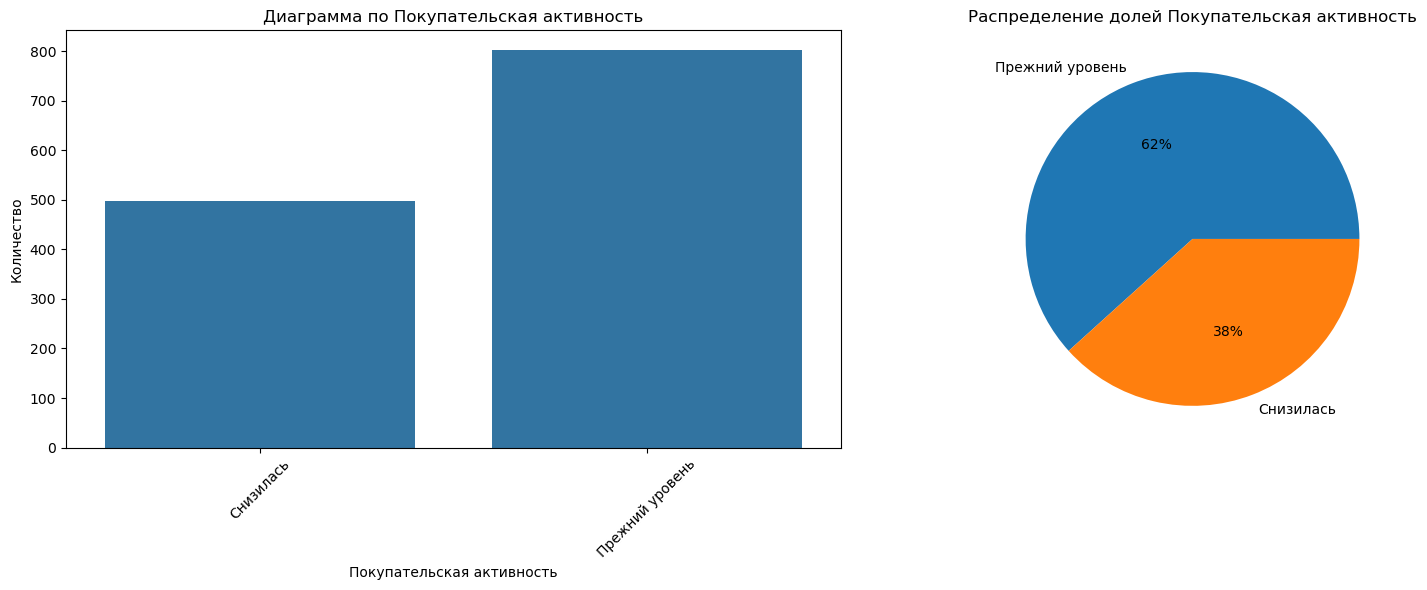

In [72]:
cat_diag(market_file, 'покупательская_активность', 'Покупательская активность')

Видим, что у большенства остается прежний уровень# Построим график Покупательской активности

### Анализ типа сервиса

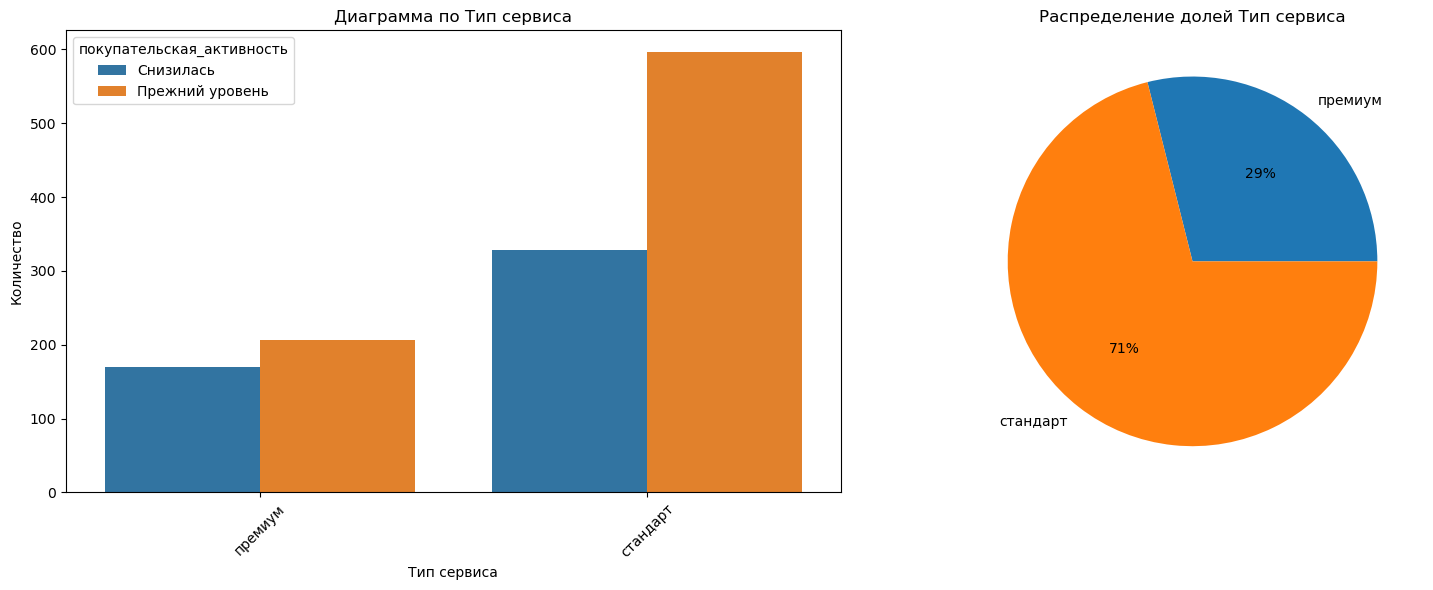

In [75]:
cat_diag(market_file, 'тип_сервиса', 'Тип сервиса', 'покупательская_активность')

Видно, что у премиум пользователей покупательная активности в процентном соотношении снижена больше.

### Анализ данных по разрешению сообщать о товарах

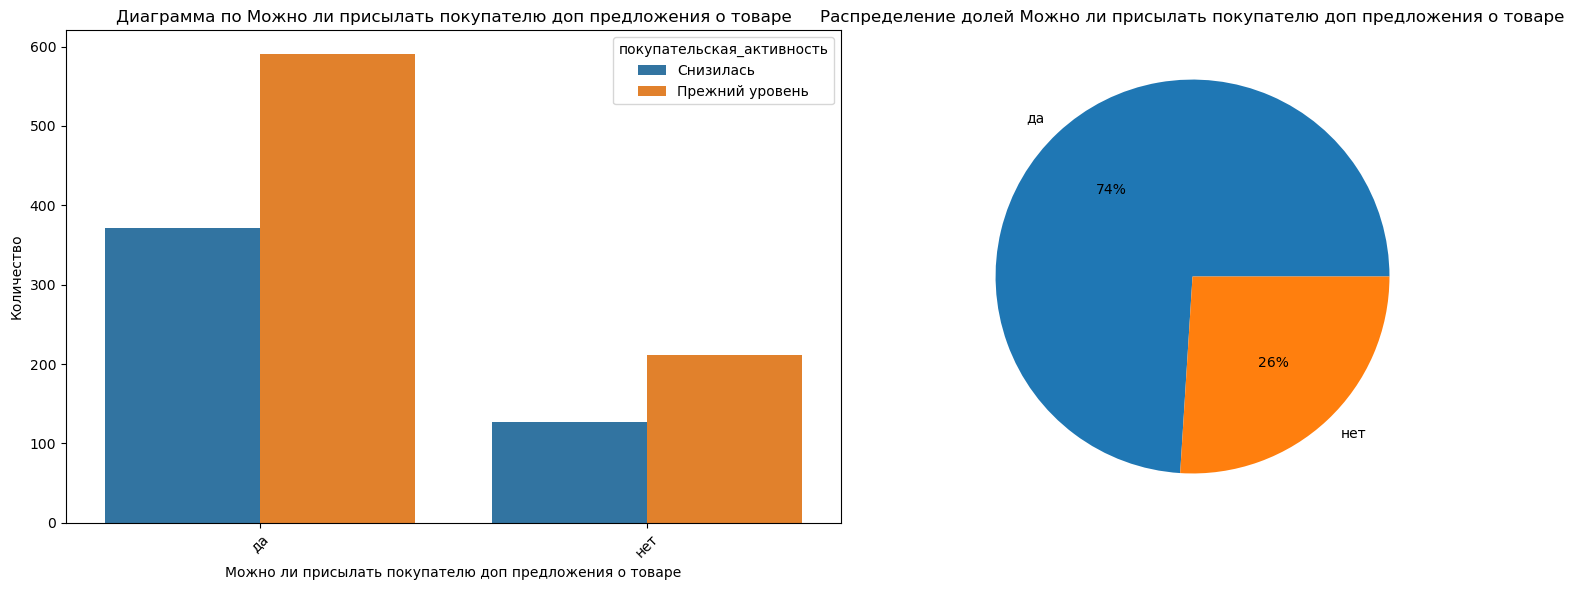

In [78]:
cat_diag(market_file, 'разрешить_сообщать', 'Можно ли присылать покупателю доп предложения о товаре', 'покупательская_активность')

74% соглашаются, что бы им присылали новые предложения. Покупательная способность снижается в не зависимсоти от рассылок.

### Анализ маркетингово взаимодействия за последние 6 месяцев

In [81]:
market_file['маркет_актив_6_мес'].describe()

count   1300.00
mean       4.25
std        1.01
min        0.90
25%        3.70
50%        4.20
75%        4.90
max        6.60
Name: маркет_актив_6_мес, dtype: float64

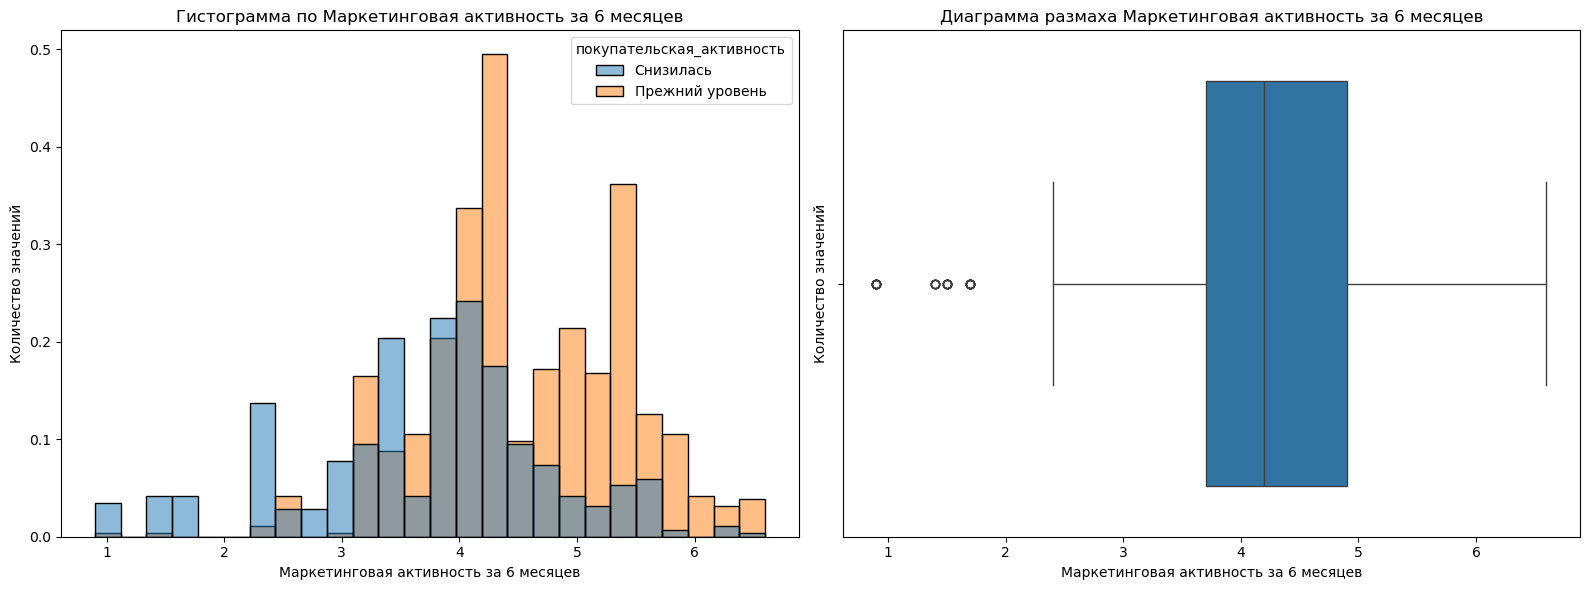

In [82]:
num_diag(market_file, market_file['маркет_актив_6_мес'], 'Маркетинговая активность за 6 месяцев', 'Количество значений', 'покупательская_активность')

В чреднем на пользователя происходит 4 активности. Так же видно, что когда мало активностей больше снижения покупательной активности.

### Анализ маркетингово взаимодействия за последний месяц

In [85]:
market_file['маркет_актив_тек_мес'].describe()

count   1300.00
mean       4.01
std        0.70
min        3.00
25%        4.00
50%        4.00
75%        4.00
max        5.00
Name: маркет_актив_тек_мес, dtype: float64

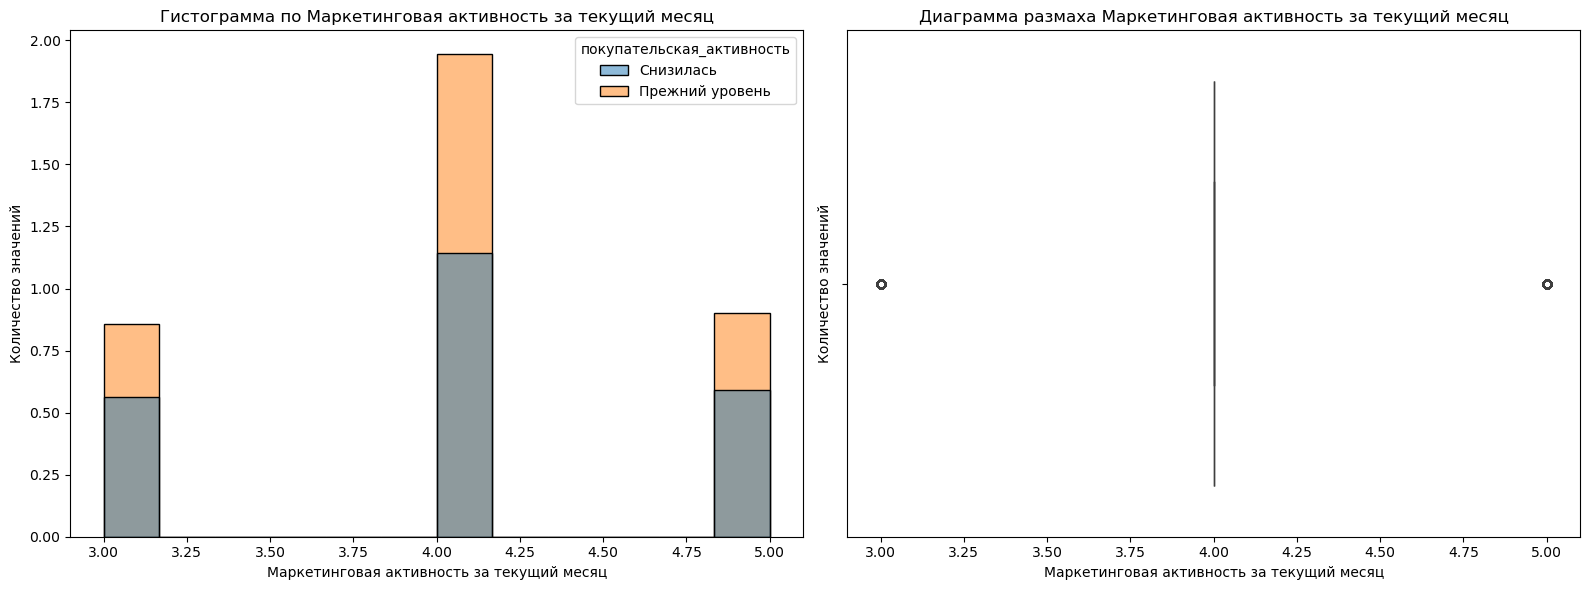

In [86]:
num_diag(market_file, market_file['маркет_актив_тек_мес'], 'Маркетинговая активность за текущий месяц', 'Количество значений', 'покупательская_активность')

Видим, что в последний месяц увеличились активности, минимальная это 3 активности, а в среднем 4 активности. 

### Анализ длительности регистрации

In [89]:
market_file['длительность'].describe()

count   1300.00
mean     601.90
std      249.86
min      110.00
25%      405.50
50%      606.00
75%      806.00
max     1079.00
Name: длительность, dtype: float64

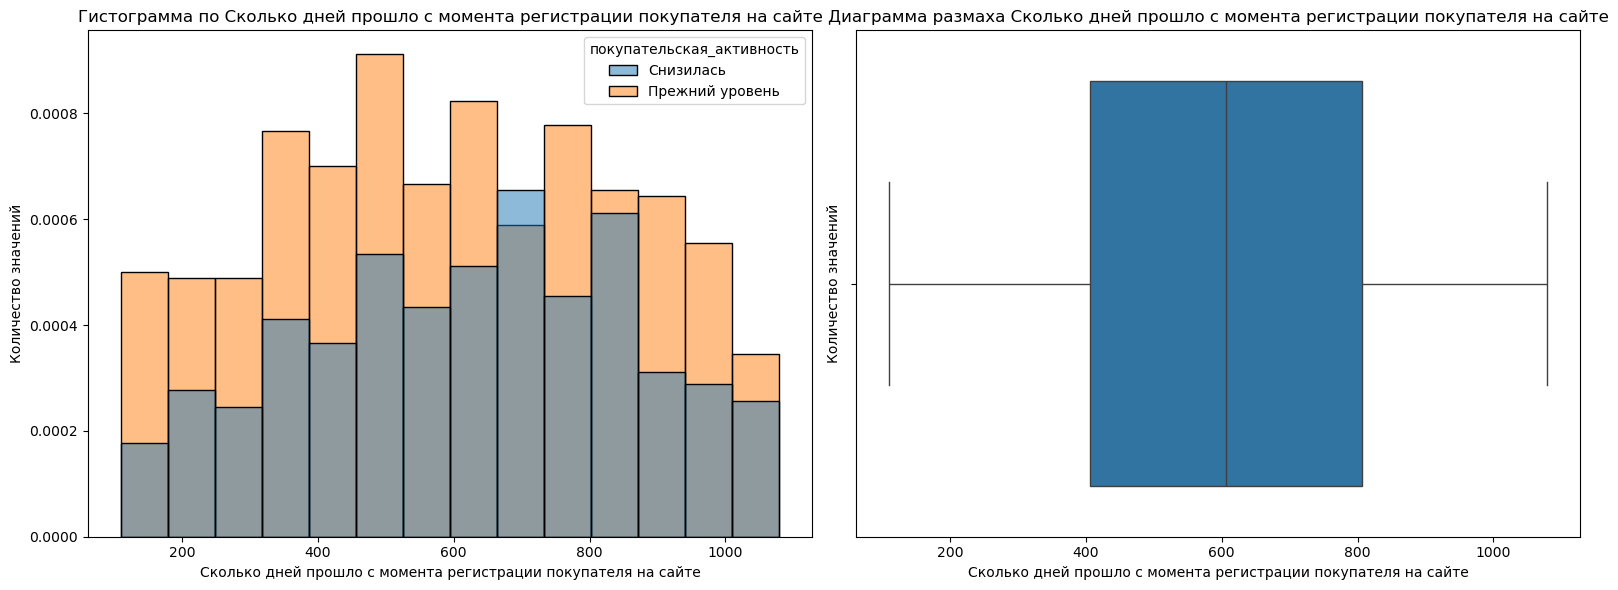

In [90]:
num_diag(market_file, market_file['длительность'], 'Cколько дней прошло с момента регистрации покупателя на сайте', 'Количество значений', 'покупательская_активность')

Больше всего зарегистрированных пользователей было 400-800 дней назад, а последнее время число регистраций снизилось

### Анализ акционных покупок

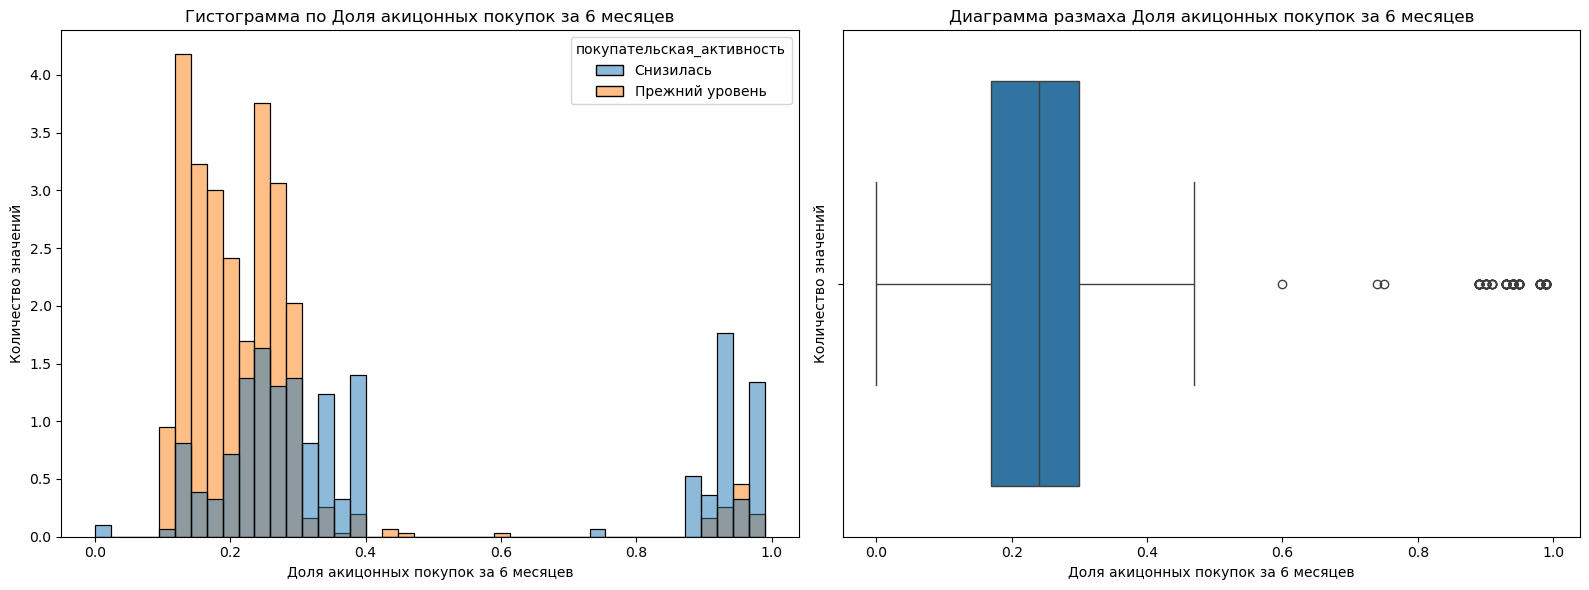

In [93]:
num_diag(market_file, market_file['акционные_покупки'], 'Доля акицонных покупок за 6 месяцев', 'Количество значений', 'покупательская_активность')

Видно, что у тех кто покупал в основном по акциям, снижаеттся покупательная активность. 

### Анализ популярной категории товара

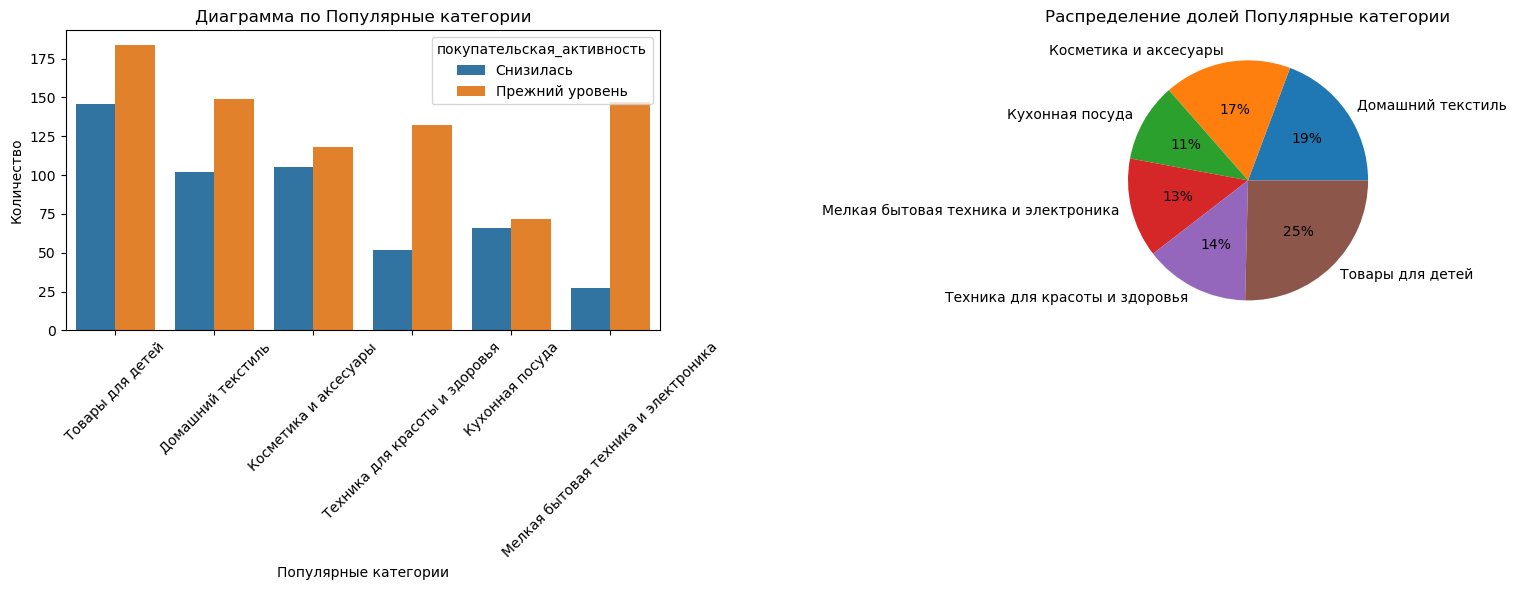

In [96]:
cat_diag(market_file, 'популярная_категория', 'Популярные категории', 'покупательская_активность')

Чаще всего покупают товары для детей, а меньше всего кухоннную посуду.

### Анализ просмотра категорий за визит в послений месяц

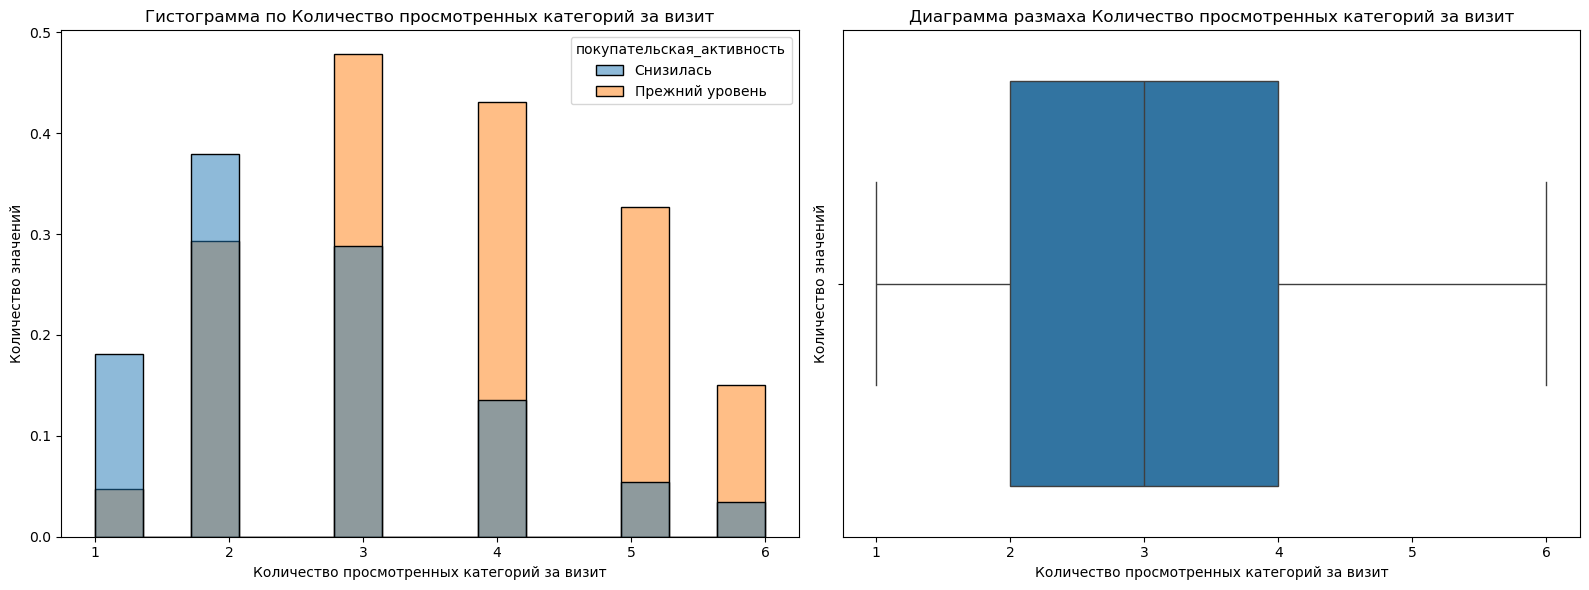

In [99]:
num_diag(market_file, market_file['средний_просмотр_категорий_за_визит'], 'Количество просмотренных категорий за визит', 'Количество значений', 'покупательская_активность')

Видно, что обычно смотрят 2-4 категориии за визит. Те кто смотрят меньше категорий покупательная активность снижается. 

### Анализ неоплаченных товаров за последние 3 месяца

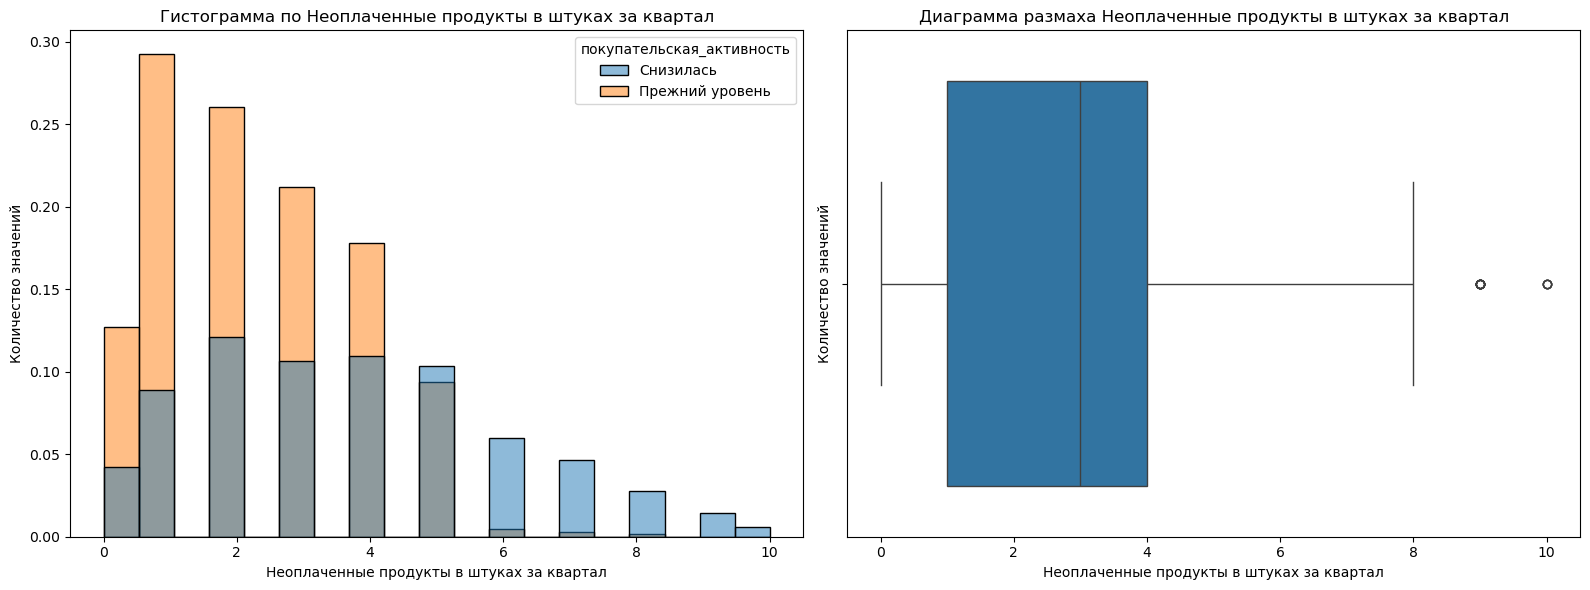

In [102]:
num_diag(market_file, market_file['неоплаченные_продукты_штук_квартал'], 'Неоплаченные продукты в штуках за квартал', 'Количество значений', 'покупательская_активность')


В основном неоплаченных товаров от 1 до 4. С увеличением неоплаченных товаров больше уменьшается покупательная активность. 

### Анализ ошибок сервисов

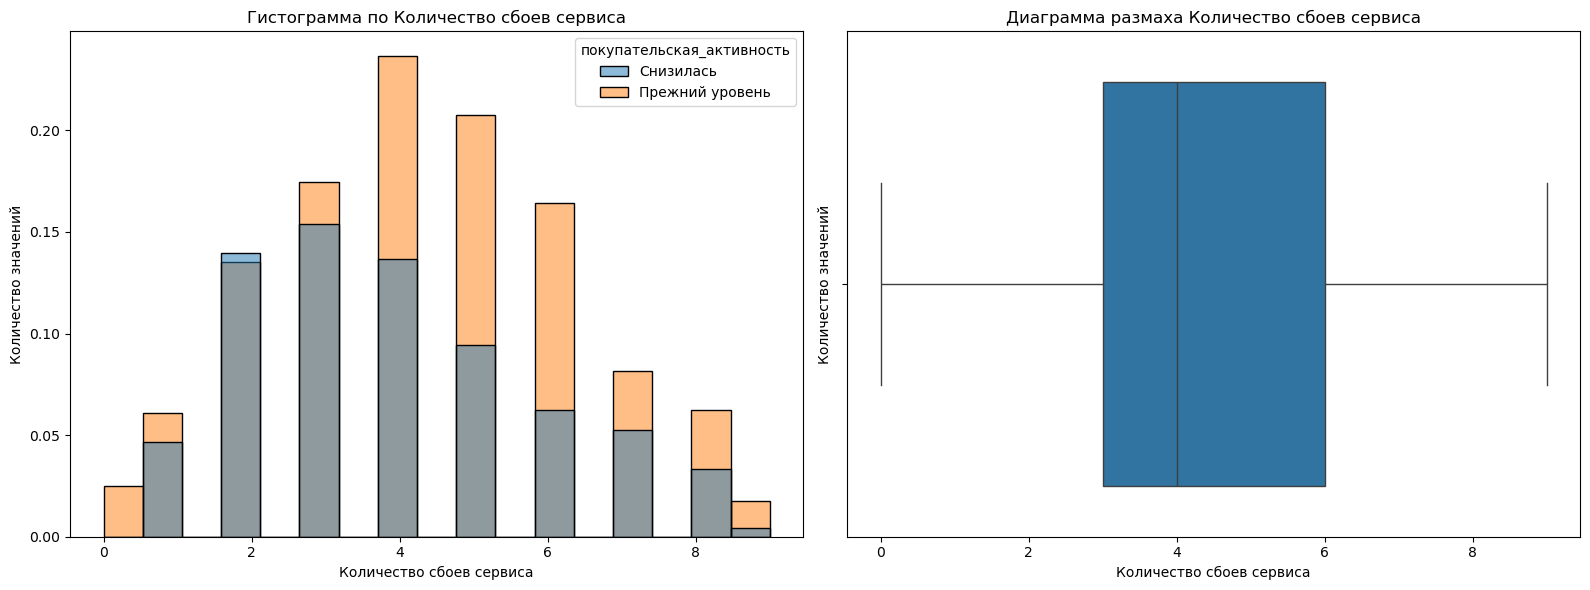

In [105]:
num_diag(market_file, market_file['ошибка_сервиса'], 'Количество сбоев сервиса', 'Количество значений', 'покупательская_активность')

В среднем 3-5 сбоев за визит, как-то это много. 

### Анализ колличества посещаемых страниц 

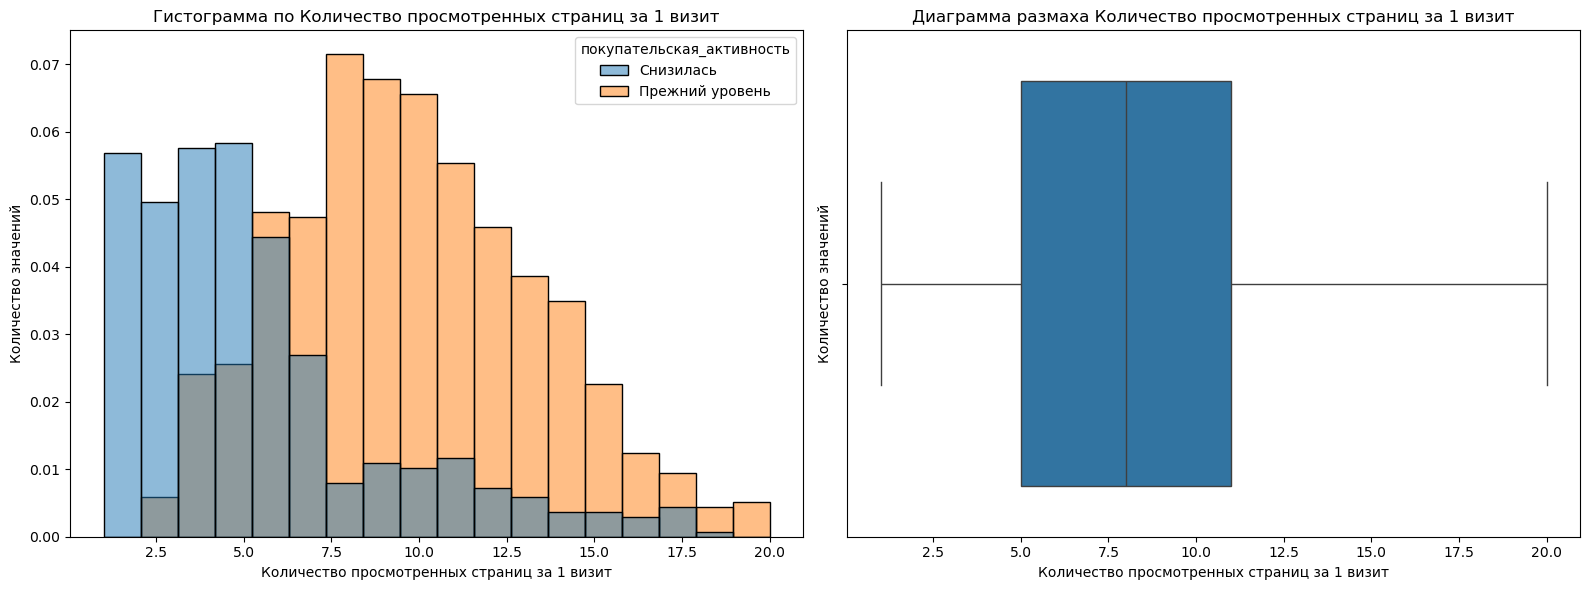

In [108]:
num_diag(market_file, market_file['страниц_за_визит'], 'Количество просмотренных страниц за 1 визит', 'Количество значений', 'покупательская_активность')

За визит просматривают где-то 5-10 страниц, видно чем больше просматривают страниц тем покупательная активность больше.

### Анализ выручки

In [111]:
market_money['период'].value_counts()

период
препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: count, dtype: int64

In [112]:
market_money['выручка'].describe()

count     3900.00
mean      5025.70
std       1777.70
min          0.00
25%       4590.15
50%       4957.50
75%       5363.00
max     106862.20
Name: выручка, dtype: float64

Видим аномально высокую выручку, посмотрим на неё.

In [114]:
market_money.sort_values(by='выручка', ascending=False).head()

,id,период,выручка
98,215380,текущий_месяц,106862.20
435,215493,текущий_месяц,7799.40
262,215435,текущий_месяц,7605.30
1481,215841,текущий_месяц,7557.00
2388,216144,текущий_месяц,7547.80


Видим, что есть один пользователь с аномальной выручкой, удаляем ёё. 

In [116]:
market_money.drop(98, inplace=True)

Проверяем низкую выручку

In [118]:
market_money.sort_values(by='выручка').head(10)

,id,период,выручка
0,215348,препредыдущий_месяц,0.00
2,215348,предыдущий_месяц,0.00
35,215359,препредыдущий_месяц,0.00
34,215359,предыдущий_месяц,0.00
29,215357,предыдущий_месяц,0.00
28,215357,препредыдущий_месяц,0.00
356,215466,текущий_месяц,2758.70
649,215564,предыдущий_месяц,2890.00
662,215568,предыдущий_месяц,2909.00
2485,216176,текущий_месяц,2952.20


Все строки с нулевой выручкой удаляем. 

In [120]:
market_money = market_money[market_money['выручка'] > 0]

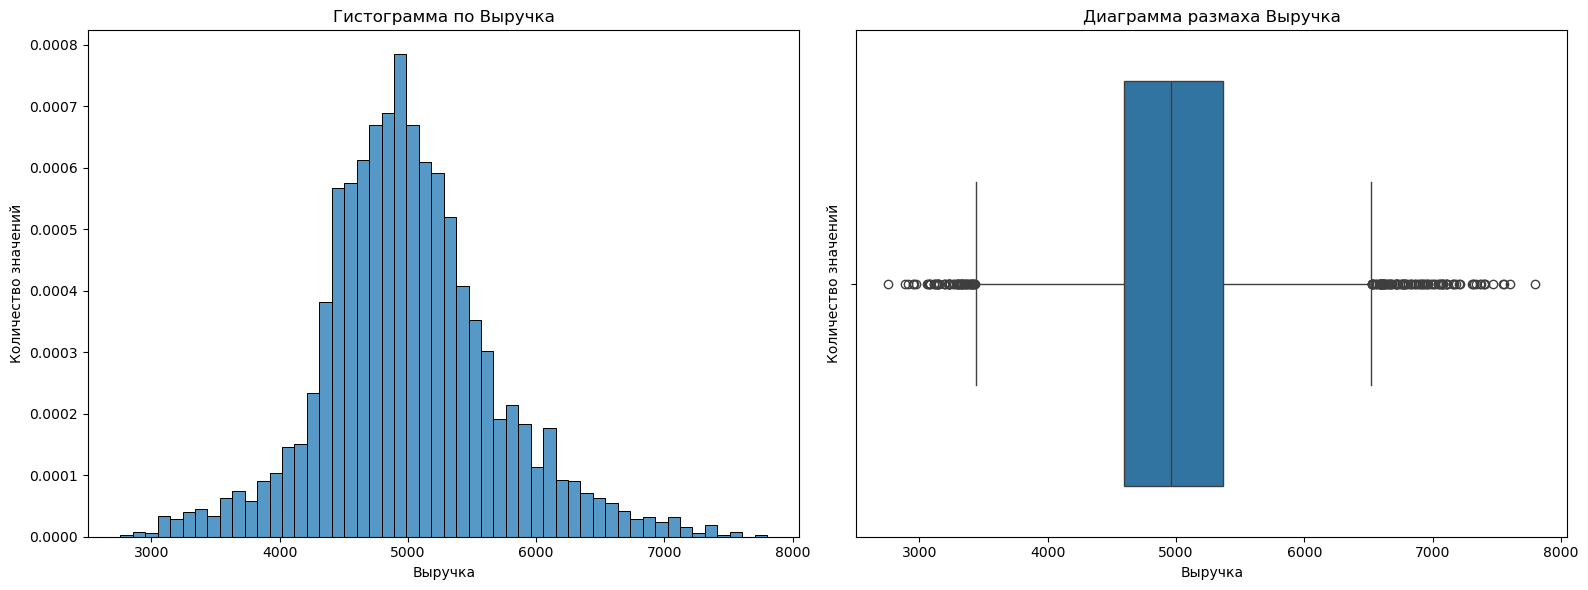

In [121]:
num_diag(market_money, market_money['выручка'], 'Выручка', 'Количество значений')

Видим, что выручка нормально распределена, среднее значение от 4500 до 5500

### Анализ проведенного времени на чайте в минутах

In [124]:
market_time['минут'].describe()

count   2600.00
mean      13.34
std        4.08
min        4.00
25%       10.00
50%       13.00
75%       16.00
max       23.00
Name: минут, dtype: float64

Аномальных выбросов нет. 

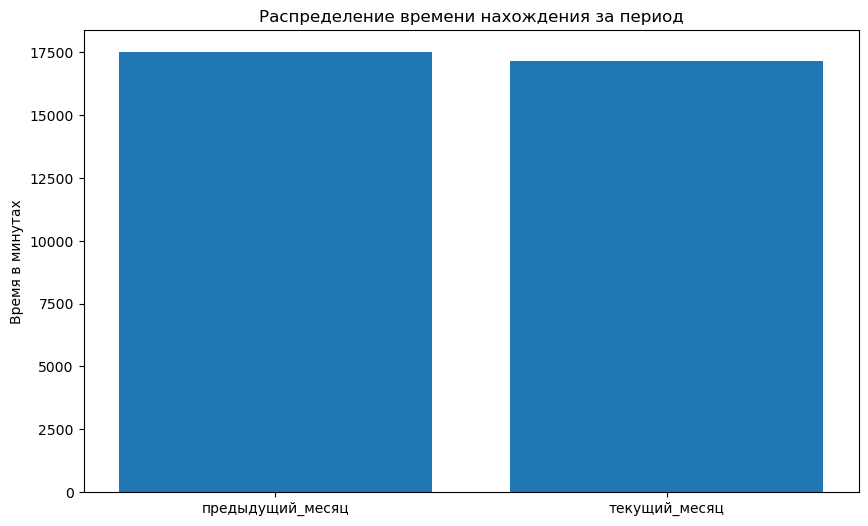

In [126]:
monthly_revenue = market_time.groupby('период').sum()
plt.figure(figsize=(10, 6))
plt.bar(monthly_revenue.index, monthly_revenue['минут'])
plt.title('Распределение времени нахождения за период')
plt.ylabel('Время в минутах')
plt.show()

Видим. что время нахождения за периоды одинаковое.

### Анализ прибыли

In [129]:
money['прибыль'].describe()

count   1300.00
mean       4.00
std        1.01
min        0.86
25%        3.30
50%        4.04
75%        4.67
max        7.43
Name: прибыль, dtype: float64

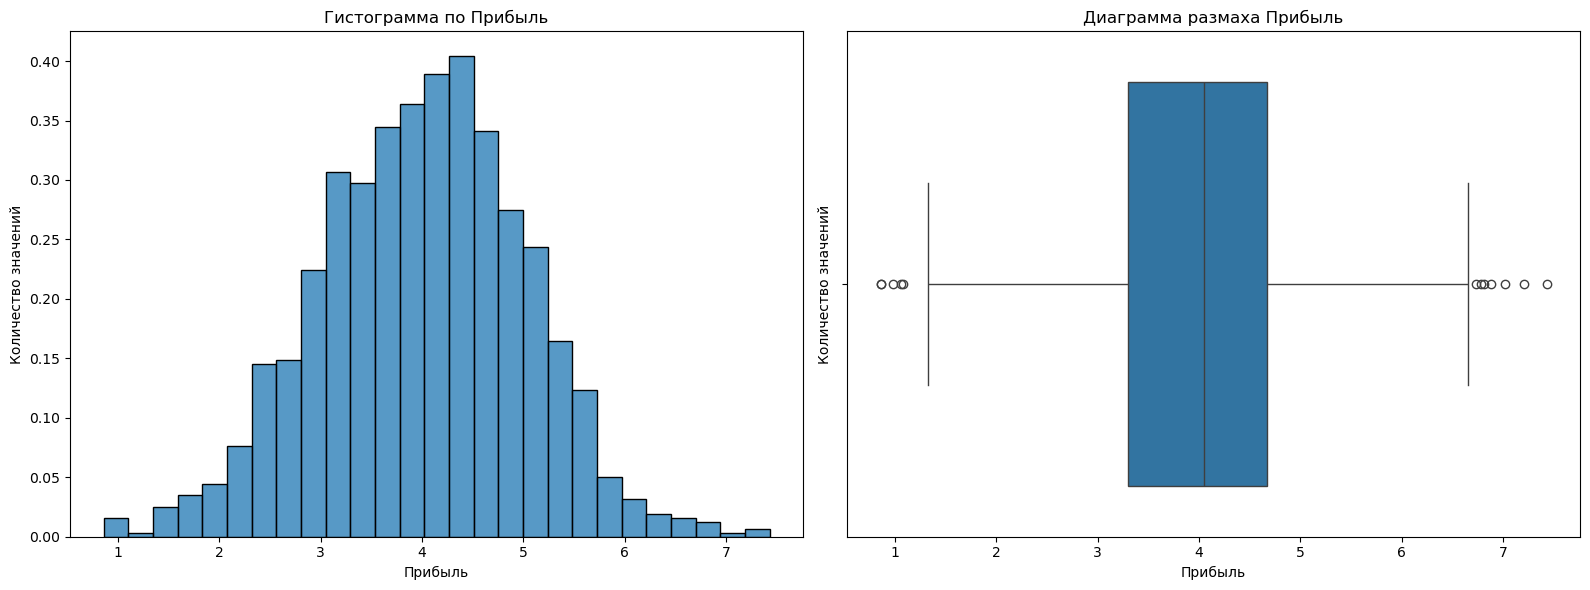

In [130]:
num_diag(money, money['прибыль'], 'Прибыль', 'Количество значений')

Аномальных значений нет. Средняя прибль 4000

### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [133]:
agg_dict = {'период': ['count']}
grouped = market_money.groupby('id').agg(agg_dict)
grouped.columns = ['count']

grouped = grouped[grouped['count'] == 3]
market_file = market_file[market_file['id'].isin(grouped.index)]

### Общий вывод

Общая активность пользователей
* Стабильность покупок: 62% покупателей сохранили уровень покупательской активности
* Премиум-аккаунт: только 29% пользователей имеют премиум-подписку

Маркетинговые активности:
* На одного пользователя приходится около 4 активностей
* Снижение активности у пользователей с низкой маркетинговой активностью за последние 6 месяцев

Пользовательское поведение, регистрация:
* Пик регистраций был 400-800 дней назад
* За последние 400 дней количество новых регистраций снизилось

Типы покупателей:
* Группа 1: эпизодические покупки акционных товаров (более многочисленная)
* Группа 2: преимущественно акционные покупки
* Снижение активности при доле акционных покупок > 0.3

Товарные категории
* Популярные категории: товары для детей
* Наименее популярные: кухонная посуда
* Просмотр категорий: за визит пользователи просматривают 2-4 категории

Поведение на сайте, навигация:
* Просмотр 5-10 страниц за визит
* Снижение активности у пользователей с малым количеством просмотров

Время на сайте:
* Предыдущий месяц: 11-17 минут
* Текущий месяц: 10-16 минут

Технические аспекты
* Сбои: пользователи сталкиваются с 3-5 сбоями при посещении

Корзина:
* Основное количество неоплаченных товаров: 1-5 за 3 месяца
* Снижение активности при >6 неоплаченных товаров

Финансовые показатели
* Выручка: присутствуют нулевые значения (планируется удаление)
* Распределение прибыли: основной диапазон 3.5-4.5

Рассылки:
* 74% пользователей согласны на получение новых предложений
* Покупательская активность снижается независимо от получения рассылок

Рекомендации
* Оптимизация премиум-тарифа для повышения удержания пользователей
* Анализ причин снижения времени на сайте
* Улучшение качества обслуживания для пользователей с высокой долей акционных покупок
* Мониторинг и устранение технических сбоев
* Оптимизация работы с корзиной покупок

## Объединение таблиц

In [137]:
market_money_grouped = market_money.pivot_table(index=['id'], columns=["период"])
market_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
market_money_grouped['id'] = market_money_grouped.index

market_time_grouped = market_time.pivot_table(index=['id'], columns=["период"])
market_time_grouped.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
market_time_grouped['id'] = market_time_grouped.index

market_full = market_file.join(market_money_grouped, on='id', lsuffix="_left", rsuffix="_выручка")
market_full = market_full.drop(['id'], axis=1)
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.join(market_time_grouped, on='id', lsuffix="_left", rsuffix="_минут")
market_full = market_full.drop(['id'], axis=1)
market_full = market_full.rename(columns={'id_left':'id'})
market_full = market_full.drop(['id_выручка', 'id_минут'], axis=1)

In [138]:
# Заменим целевые значения на 0 и 1
market_full = market_full.replace({'Прежний уровень': 0, 'Снизилась': 1}).infer_objects(copy=False)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_15416\1208315897.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  market_full = market_full.replace({'Прежний уровень': 0, 'Снизилась': 1}).infer_objects(copy=False)


In [139]:
# Делаем id индексом
market_full = market_full.set_index('id')

In [140]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1296 entries, 215349 to 216647
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская_активность            1296 non-null   int64  
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   акционные_покупки                    1296 non-null   float64
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит            

In [141]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5,5216.00,4472.00,4971.60,12.00,10.00
215350,1,стандарт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,5457.50,4826.00,5058.40,8.00,13.00
215351,1,стандарт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4,6158.00,4793.00,6610.40,11.00,13.00
215352,1,стандарт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2,5807.50,4594.00,5872.50,8.00,11.00
215353,1,стандарт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,4738.50,5124.00,5388.50,10.00,10.00


Выполнено объединение таблиц, заменены целевые значения на числовые

## Корреляционный анализ

In [144]:
# создадим матрицу корреляции
phk_m = market_full.phik_matrix(verbose=False)

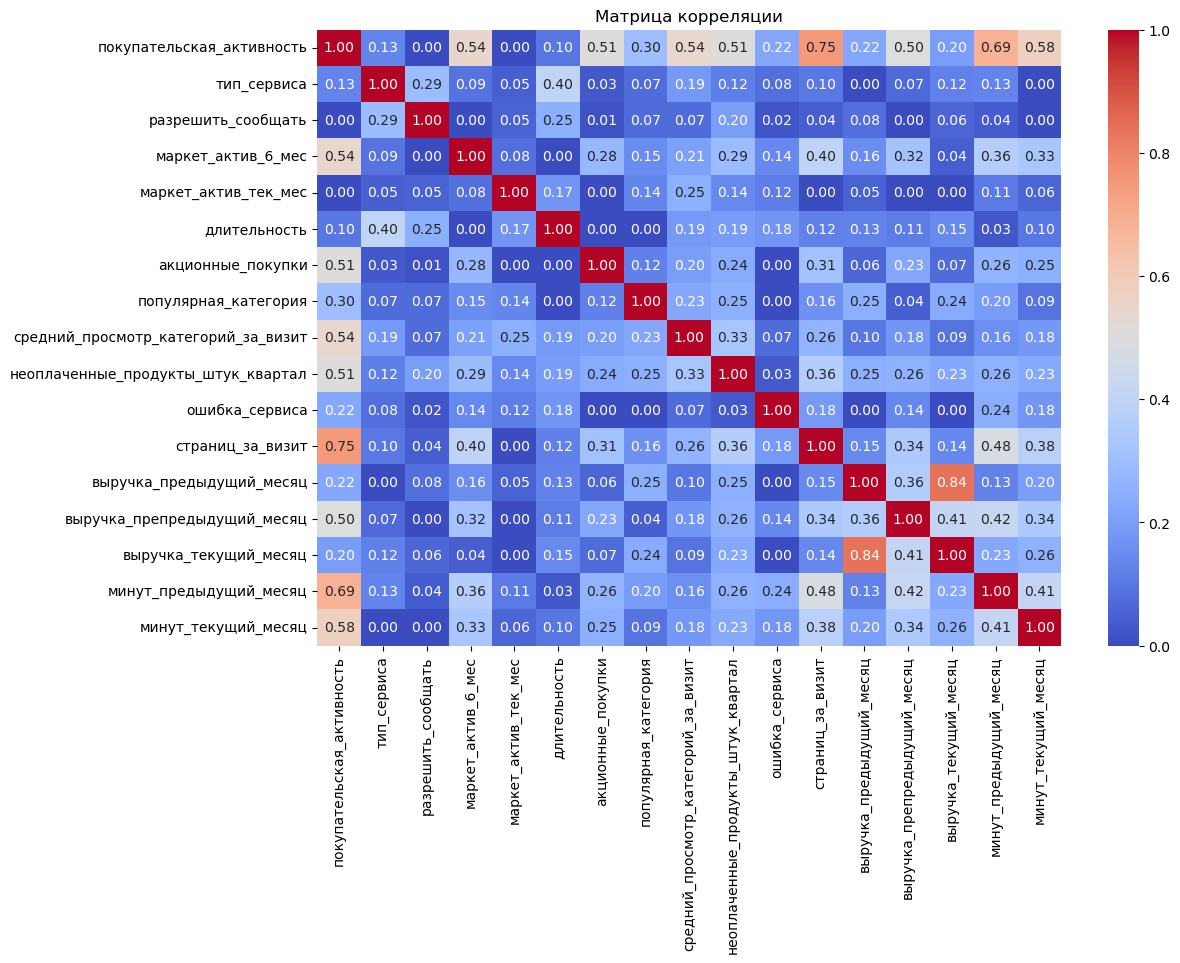

In [145]:
# Визуализируем матрицу корреляции 
plt.figure(figsize=(12, 8))
plt.title('Матрица корреляции')
sns.heatmap(phk_m, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Сильная положительная корреляция между признаками: выручка_предыдущий_месяц и выручка_текущий_месяц (0.84): Увеличение одного показателя связано с увеличением другого.

Сильная положительная корреляция с таргетами: страниц_за_визит (0.75), время предыдущий месяц (0.69), время текущий месяц (0.58). Можно сказать что активность пользователя на сайте сильно влияет на покупательскую активность.

Так же есть небольшая корреляция с маркетинговой активностью за последние 6 месяцев, из этого можно сделать вывод, что маркетинг помогает удерживать высокую активность. 

### Рассчитываем мультиколлениарность

In [148]:
cols = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 
    'акционные_покупки', 'средний_просмотр_категорий_за_визит', 
    'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
    'страниц_за_визит', 'выручка_предыдущий_месяц', 
    'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 
    'минут_предыдущий_месяц', 'минут_текущий_месяц'
]

# Выбираем только числовые признаки
X = market_full[cols]

# Добавляем константу
X = sm.add_constant(X)

# Вычисляем VIF для каждого признака
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

                               Variable    VIF
0                                 const 352.52
1                    маркет_актив_6_мес   1.22
2                  маркет_актив_тек_мес   1.04
3                          длительность   1.10
4                     акционные_покупки   1.19
5   средний_просмотр_категорий_за_визит   1.18
6    неоплаченные_продукты_штук_квартал   1.20
7                        ошибка_сервиса   1.08
8                      страниц_за_визит   1.42
9              выручка_предыдущий_месяц   4.26
10          выручка_препредыдущий_месяц   1.61
11                выручка_текущий_месяц   3.90
12               минут_предыдущий_месяц   1.53
13                  минут_текущий_месяц   1.32


### Вывод

Корреляция с целевым признаком является
* Маркет_актив_6_мес - маркетинг помогает поддерживать высокую покупательную активность.
* Акционные_покупки - акции на товар помогают поддерживать высокую покупательную активность
* Неоплаченные_продукты_штук_квартал - при наличии в корзине товаров, поддерживается покупательная активность
* Выручка_препредыдущий_месяц - видимо те кто делал заказы заходят и покупают далее

Остальные признаки, свидельствуют о том чем больше активность на сайте тем и больше покупательная активность
* Средний_просмотр_категорий_за_визит
* Страниц_за_визит
* минут_предыдущий_месяц
* минут_текущий_месяц

После проверки мультиколлинеальности выяснилось, что у всех признаков, кроме выручка_предыдущий_месяц и выручка_текущий_месяц, мультиколлинеальности отсутсвует. А у этих двух признаков присутствует слабая мультиколлинеальность

## Использование пайплайнов

Добавляем столбец с категоризацией частоты покупки. 

In [153]:
market_full['акционные_покупки'] = market_full['акционные_покупки'].apply( 
    lambda x: 'Часто покупает по акции' if x>= 0.5 else 'Редко покупает по акции' 
)

In [154]:
# Задаем параметры для моделепй
RANDOM_STATE = 42
TEST_SIZE = 0.25

Делим данные на тестовые и тренировочные.

In [156]:
X = market_full.drop(['покупательская_активность'], axis=1)
y = market_full['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)

In [157]:
market_full.head()

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,1,премиум,да,4.40,4,819,Часто покупает по акции,Товары для детей,4,4,2,5,5216.00,4472.00,4971.60,12.00,10.00
215350,1,стандарт,нет,4.90,3,539,Редко покупает по акции,Домашний текстиль,5,2,1,5,5457.50,4826.00,5058.40,8.00,13.00
215351,1,стандарт,да,3.20,5,896,Часто покупает по акции,Товары для детей,5,0,6,4,6158.00,4793.00,6610.40,11.00,13.00
215352,1,стандарт,нет,5.10,3,1064,Часто покупает по акции,Товары для детей,3,2,3,2,5807.50,4594.00,5872.50,8.00,11.00
215353,1,стандарт,да,3.30,4,762,Редко покупает по акции,Домашний текстиль,4,1,1,4,4738.50,5124.00,5388.50,10.00,10.00


Подготавливаем список колонок для того, что бы их кодировать разными способами

In [159]:
ohe_columns = ['тип_сервиса', 'разрешить_сообщать','популярная_категория']
ord_columns = ['акционные_покупки']
num_columns = X.select_dtypes(include='number').columns.tolist()

Добавляем OHE-кодирование в пайплайн

In [161]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
       
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

Ordinal-кодирование 

In [163]:
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high']
                ],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

Объединяем в пайплайн промежуточные преобразования

In [165]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Формируем финальный пайплайн

In [167]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Формируем параметры для моделей

In [208]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']    
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,15),
        'models__p': range(1,3),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': [0.001, 0.01, 0.1, 1],
        'models__penalty': ['l1', 'l2'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

Запускаем пайплайн

In [211]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search.fit(X_train, y_train)

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).

In [174]:
print('Метрика ROC-AUC для лучшей модели:\n', round(randomized_search.best_score_, 4)) 
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_params_) 

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_score_'

In [ ]:
y_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_pred), 4)}')

Вывод:

Была найдена и обучена модель для определения снижения активности покупателей сервиса. 

Лучшие результаты показала модель LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear'). 

Метрика roc_auc для тестовой выборки показла результат 0.90, для кросс валидацинной 0.92. Модель хорошо справляется с предсказанием. 

## Анализ важности признаков

Выполним конкретный этап пайплайн

In [ ]:
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

Инициализируем метод SHAP с наилучшей моделью

In [ ]:
explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_2)

In [ ]:
# Обработка тестовых данных
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)

In [ ]:
# Получение названий признаков и создание датафрейма
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

In [ ]:
# Расчет значений SHAP
shap_values = explainer(X_test_2)

Построение графиков

In [ ]:
plt.rcParams.update({
    'font.size': 25,  
    'axes.titlesize': 25, 
    'axes.labelsize': 25, 
    'xtick.labelsize': 25,  
    'ytick.labelsize': 25,  
    'legend.fontsize': 25,  
    'figure.titlesize': 25 
})

shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="bar", 
    max_display=30, 
    plot_size=(15, 15) 
)

shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="dot", 
    max_display=30, 
    plot_size=(15, 15)  
)

plt.show()

**Вывод**

Для модели выжны следующие признаки это: Акционные покупки, Мелкая бытовая техника и электроника, Просмотр категорий за визит, Страниц за визит, Минуты в предыдущий месяц.
Малозначимыми признаками оказались:Популярная категория(кроме бытовой техники и техники для красоты и здоровья), Маркет_актив_тек_мес, Разрешить сообщать, Тип_сервиса.

По графику beeswarm видно:

ord_акционные_покупки_категория: Высокие значения этого признака увеличивают SHAP значения и, следовательно, увеличивают вероятность того, что покупательная активность снизится. Это означает, что наличие акционных покупок больше связано со снижением покупательной активности.

num_средний_просмотр_категорий_за_визит  и num_страницы_за_визит : Низкие значения этих признаков увеличивают SHAP значения, что указывает на увеличение вероятности снижения покупательной активности. То есть чем меньше человек просмотрит категорий и посетит страниц за визит, тем выше вероятность того, что его покупательная активность снизится.

num_минут_текущий_месяц и num_минут_предыдущий_месяц: Эти признаки имеют смешанное влияние, где высокие значения могут как увеличивать, так и уменьшать вероятность целевого события, в зависимости от конкретного случая.

Остальные признаки также имеют влияние, но оно менее выражено.

## Сегментация покупателей

Выбираем предсказание модели, добавляем датасеты, объединяем и добавляем данные по выручке. 

In [ ]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [ ]:
X_test_full = X_test.copy()
X_train_full = X_train.copy()
X_test_full['вероятность_снижения'] = y_test_proba
X_train_full['вероятность_снижения'] = y_train_proba
df_full = pd.concat([X_train_full, X_test_full])

money = money.set_index('id')
df_full = df_full.join(money)

In [ ]:
df_full.head()

Делим на сегменты. Часто покупающих по скидке и имеющийх высокую вероятность снижения покупательской активности.

In [ ]:
df_full['сегмент'] = df_full.apply( lambda row: 'исследуемый_сегмент' if row['вероятность_снижения'] > 0.8 
                                   and row['акционные_покупки']=='Часто покупает по акции'
                                   else 'остальные_пользователи', axis=1
                                  )

In [ ]:
df_full[df_full['сегмент'] == 'исследуемый_сегмент']

In [ ]:
# Выираем исследуемый сегмент
df_sigm = df_full[df_full['сегмент'] == 'исследуемый_сегмент']

In [ ]:
def categoral_unique(df, col):
    value_counts = df[col].value_counts()
    plt.figure(figsize=(8,8))
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение по {col}', fontsize=16)
    plt.show()

In [ ]:
categoral_unique(df_sigm, 'популярная_категория')

Больше всего покупают детские товары

In [ ]:
categoral_unique(df_sigm, 'тип_сервиса')

Преобладают пользователи со стандарной подпиской

In [ ]:
def histogram(df, col, target):
    plt.figure(figsize=(18,10))
    plot = sns.histplot(df, bins=20, kde=True, hue=target, x=col)
    plot.set_title(f'Рапределение по {col}', fontsize=15)
    plot.set_ylabel('Количество', fontsize=15)

In [ ]:
histogram(df_full, 'страниц_за_визит', 'сегмент')

Из графика видно, что пользователи из выбранного нами сегмента просматривают мньше страниц, видимо посещают только страницы с товарами со скидкой.

In [ ]:
histogram(df_full, 'средний_просмотр_категорий_за_визит', 'сегмент')

На графике видно, что категорий за визит мало, так же потому что просматривают только товары по акции.

In [ ]:
histogram(df_sigm, 'неоплаченные_продукты_штук_квартал', 'сегмент')

Видим, что пользователи из иследуемого сегмента много держат в корзине товаров. 

In [ ]:
histogram(df_full, 'маркет_актив_6_мес', 'сегмент')

Из графика видно, что в иследуемом сегменте меньше маркетинга. 

In [ ]:
histogram(df_full, 'маркет_актив_тек_мес', 'сегмент')

В текущем месяце маркетинга меньше чем за последние 6 месяцев. 

In [ ]:
histogram(df_sigm, 'разрешить_сообщать', 'сегмент')

Видим, что большенство пользователей дают разрешение на собщения об акциях. 

Вывод по сегментации напишу в общем выводе.


## Общий вывод

В ходе исследования были поставлены две основные задачи:

* Построение модели для прогнозирования снижения покупательской активности пользователей интернет-магазина “В один клик”
* Исследование и анализ конкретного сегмента пользователей

Исследование включало следующие ключевые этапы:

Предобработка данных:
* Загрузка четырех CSV-файлов с различными типами данных
    * с данными о поведении покупателя на сайте, коммуникации с ним и его продуктовом поведении.
    * с данными о выручке, которую получает магазин с покупателя за период
    * с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода
    * с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю Данные были загружены в датафреймы библиотеки pandas.
* Стандартизация названий признаков
* Проверка и обработка пропусков, их не нашлось.
* Исправление опечаток в категориальных признаках

Анализ данных:
* Исследование распределения всех признаков
* Выявление корреляций с целевым признаком
* Проверка на мультиколлинеарность
* Объединение датасетов в единый датафрейм

Результаты анализа, корреляционный анализ показал наличие связи между покупательской активностью и следующими признаками:
* Активность на маркетплейсе за 6 месяцев
* Поведение при акционных покупках
* Среднее количество просматриваемых категорий
* Количество неоплаченных товаров
* Количество просматриваемых страниц
* Выручка за предыдущие периоды
* Время, проведенное на сайте

Моделирование, обучение моделей проводилось с использованием:
* KNeighborsClassifier
* DecisionTreeClassifier
* LogisticRegression
* SVC

**Лучшей оказалась модель LogisticRegression** с параметрами:
* LogisticRegression(C=2, penalty='l1', random_state=42, solver='liblinear')

Показатели качества:
* ROC-AUC (train): 0.90
* ROC-AUC (test): 0.92

Анализ важности признаков выявил:
* Ключевые факторы: акционные покупки и время на сайте
* Менее значимые: категории товаров и коммуникации с пользователем

**Сегментация.**

Исследуемый сегмент включал пользователей, часто совершающих акционные покупки с высокой вероятностью снижения активности

Рекомендации по улучшению:

Таргетированная настройка главной страницы, для регулярного обновления акционных предложений, больше отображать категорий для детей и текстиля. Можно присылать дополнительные скидки на товары из корзины, т.к. у польщователей исследуемой категории их много. 

Исследование показало, что:

* Модель успешно справляется с прогнозированием снижения активности
* Ключевым фактором является время, проведенное пользователем на сайте
* Оптимизация главной страницы может существенно повысить конверсию